In [42]:
import numpy as np
import sys
import json
import os
import utils
from scipy.special import softmax as softmax
from statistics import median
import matplotlib.pyplot as plt

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=1000)

In [9]:
#MANUAL INPUT
coarse=0           #coarse = 0 ; non-coarse = 1
dth=12             #threshold for data [Available:5,12,15]
M=3                #memory states [Available:1,2,3,4]
A=4                #action size 4 -> [up,left,right,up]


max_obs = 10       # distinct observations for rewards
O = 2              # distinct observations for actions [0, 1, 2, .., O-1]

symmetry=1
replica=0          #replica -- for non-coarse policies

#Dimension of grid: Lx by Ly
Lx = 92            
Ly = 131

#Location of source (Lx0,Ly0)
Lx0 = 45.5
Ly0 = 91

if coarse == 1:    #change size and center for coarse set-up
    Lx=Lx-1
    Lx0=Lx0-45.5
    
lr=0.01            #learning rate
find_range=1.1     #radius from source location to be considered as found target
gamma=0.99975      #discount rate
V=100              #wind velocity for model plume


#combined action space = M * A, lM0, lM1, ... rM0, rM1, ..., uM0, uM1, ..., dM0, dM1, ...
a_size = A * M
L = Lx*Ly

# cost move!
cost_move = 1-gamma
reward_find=0.0

# probability of track
beta = 1
sigma = 4

In [10]:
#load plume data (already pre-processed)
data=np.loadtxt('data/exp_plume_symmetric_threshold{}.dat'.format(dth))
if coarse == 1:
    data=np.loadtxt('data/exp_plume_symmetric_coarse_threshold{}.dat'.format(dth))
data=np.array(data)

#LOADING SAVED POLICY
sub=0
new=0
#new=0 means the saved optimal policy we provided
#new=1 means the policy you saved as a result
#sub= 0 : best, 1: second best 
if new==0:
#load optimized policy
    name_folder='saved_policies/A{}M{}TH{}sub{}co{}'.format(A,M,dth,sub,coarse)
    th = np.loadtxt(name_folder + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(name_folder + '/file_Q.out')
    eta = np.loadtxt(name_folder + '/file_eta.out')
elif new==1:
#load your policy
#insert after output/ inside the '' the name of the folder 
    name_folder='output/'
    th = np.loadtxt(name_folder + '/file_theta.out')
    th = th.reshape(O, M, a_size)
    Q = np.loadtxt(name_folder + '/file_Q.out')
    eta = np.loadtxt(name_folder + '/file_eta.out')

In [13]:
#INITIALIZATIONS
PObs_lim, RR, PObs = utils.create_PObs_RR(Lx, Ly, Lx0, Ly0, find_range, cost_move, reward_find, M, sigma, max_obs, O, A, V, data)
PObs_lim = np.abs(PObs_lim)

#distribution relative to the PObs_lim
rho0 = np.zeros(M*Lx*Ly)
rho0[:Lx] = (1-PObs_lim[0,:Lx])/np.sum((1-PObs_lim[0,:Lx]))

# ++++++++++++++++++
pi = softmax(th, axis=2)
print('the average value of the policy is:')
print(utils.get_value(Q, pi, PObs_lim, L, rho0))

the average value of the policy is:
-0.1501240765201965


In [14]:
#DATA FOR TRANSITION PROBABILITIES
print('policy p(a,m*|m,y)')
print('for y=o')
print(pi.reshape(O,M,M,A)[0])
print('for y=1')
print(pi.reshape(O,M,M,A)[1])

policy p(a,m*|m,y)
for y=o
[[[0.      0.05046 0.91437 0.     ]
  [0.      0.      0.      0.     ]
  [0.      0.03517 0.      0.     ]]

 [[0.      0.      0.      0.     ]
  [0.      0.9528  0.      0.001  ]
  [0.04569 0.      0.      0.0005 ]]

 [[0.      0.      0.      0.     ]
  [0.04794 0.      0.      0.00088]
  [0.77777 0.      0.      0.17341]]]
for y=1
[[[0.      0.      1.      0.     ]
  [0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.      0.00252 0.99739 0.00009]
  [0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.      0.00001 0.99993 0.00007]
  [0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]]


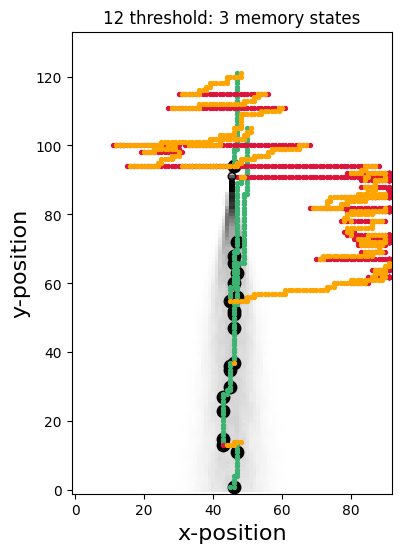

In [45]:
#TRAJECTORY sample
trj, ret, _ = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, gamma, PObs_lim, rho0, A)
scatter_x = trj[1:,1]
scatter_y = trj[1:,2]
group = trj[1:,3]
cdict = {2: 'orange', 0: 'mediumseagreen', 1: 'crimson', 3:'blue'}

fig, ax = plt.subplots()

ix = np.where(trj[1:,4] > 0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = 'black', s = 80)
ix = np.where(group == 0.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[0], label = 'Memory 0', s = 8)
ix = np.where(group == 1.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[1], label = 'Memory 1', s = 8)
ix = np.where(group == 2.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[2], label = 'Memory 2', s = 8)
ix = np.where(group == 3.0)
ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[3], label = 'Memory 3', s = 8)
#ax.legend()
ax.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:],cmap='Greys')
fig.set_size_inches(10, 6)
crange=plt.Circle((Lx0,Ly0),find_range,fill=False)
ax.set_aspect(1)

ax.add_artist(crange)
plt.title('{} threshold: {} memory states'.format(dth, M))
plt.xlim((-1,92))
plt.ylim((-1,133))
plt.xlabel('x-position',fontsize=16)
plt.ylabel('y-position',fontsize=16)
plt.show()

<ipython-input-26-439eb34a197d>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


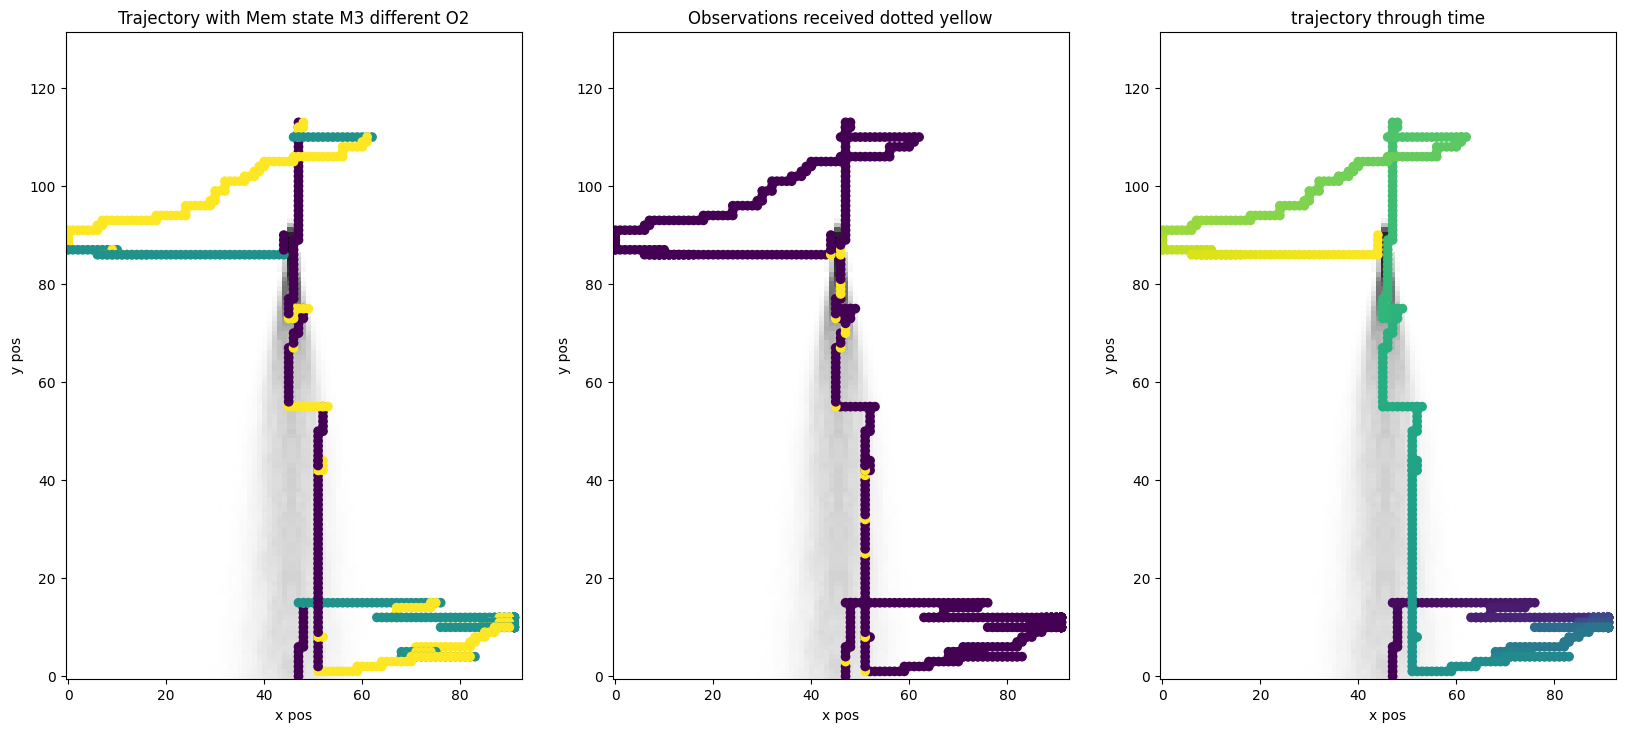

In [26]:
#PLOTTING TRAJECTORIES
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

plt.style.use('seaborn')

ax1.set_xlim([-0.5, Lx+0.5])
ax1.set_ylim([-0.5, Ly+0.5])
ax2.set_xlim([-0.5, Lx+0.5])
ax2.set_ylim([-0.5, Ly+0.5])
ax3.set_xlim([-0.5, Lx+0.5])
ax3.set_ylim([-0.5, Ly+0.5])


ax1.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])
ax2.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])
ax3.imshow((1-PObs_lim[0,:]-5).reshape(M,Ly,Lx)[0,:])


plt.style.use('default')

plt.rcParams["figure.figsize"] = (20,11)

ax1.scatter(trj[1:,1], trj[1:,2], c=trj[1:,3])
ax1.set_aspect('equal')
ax1.set_title('Trajectory with Mem state M{} different O{}'.format(M, O))
ax1.set_xlabel('x pos')
ax1.set_ylabel('y pos')

#plt.clabel('Memory state')

#plt.plot(PObs[1][:L])

ax2.set_aspect('equal')
ax2.set_title('Observations received dotted yellow')
ax2.scatter(trj[1:,1], trj[1:,2], c=trj[1:,4])

ax2.set_xlabel('x pos')
ax2.set_ylabel('y pos')
#plt.clabel('Memory state')

ax3.set_aspect('equal')
ax3.set_title('trajectory through time')
ax3.scatter(trj[1:,1], trj[1:,2], c=np.arange(trj.shape[0]-1))

ax3.set_xlabel('x pos')
ax3.set_ylabel('y pos')

np.savetxt('trajectory.txt', trj[1:])
np.savetxt('PObs.txt', (1-PObs_lim[0,:]).reshape(M,Ly,Lx)[0,:])



In [27]:
#TIME DISTRIBUTIONS of search time 
#timedistributions

Nep = 1000    #number of trajectories to reproduce
av_ret = 0.
T = []
maxT = 10000  #maximum search time, not found before maxT would be counted as "failed search"

for i in range(Nep):
    _, ret, tau = utils.single_traj_obs(softmax(th, axis=2), Lx, Ly, Lx0, Ly0, find_range, maxT, PObs_lim, rho0, A)
    av_ret += ret
    T.append(tau)
print('Success Rate: {}%'.format(100*av_ret / Nep))


Success Rate: 1.0%


mean search time: 1440.438
median: 1049.0
std deviation: 1344.0030900842453


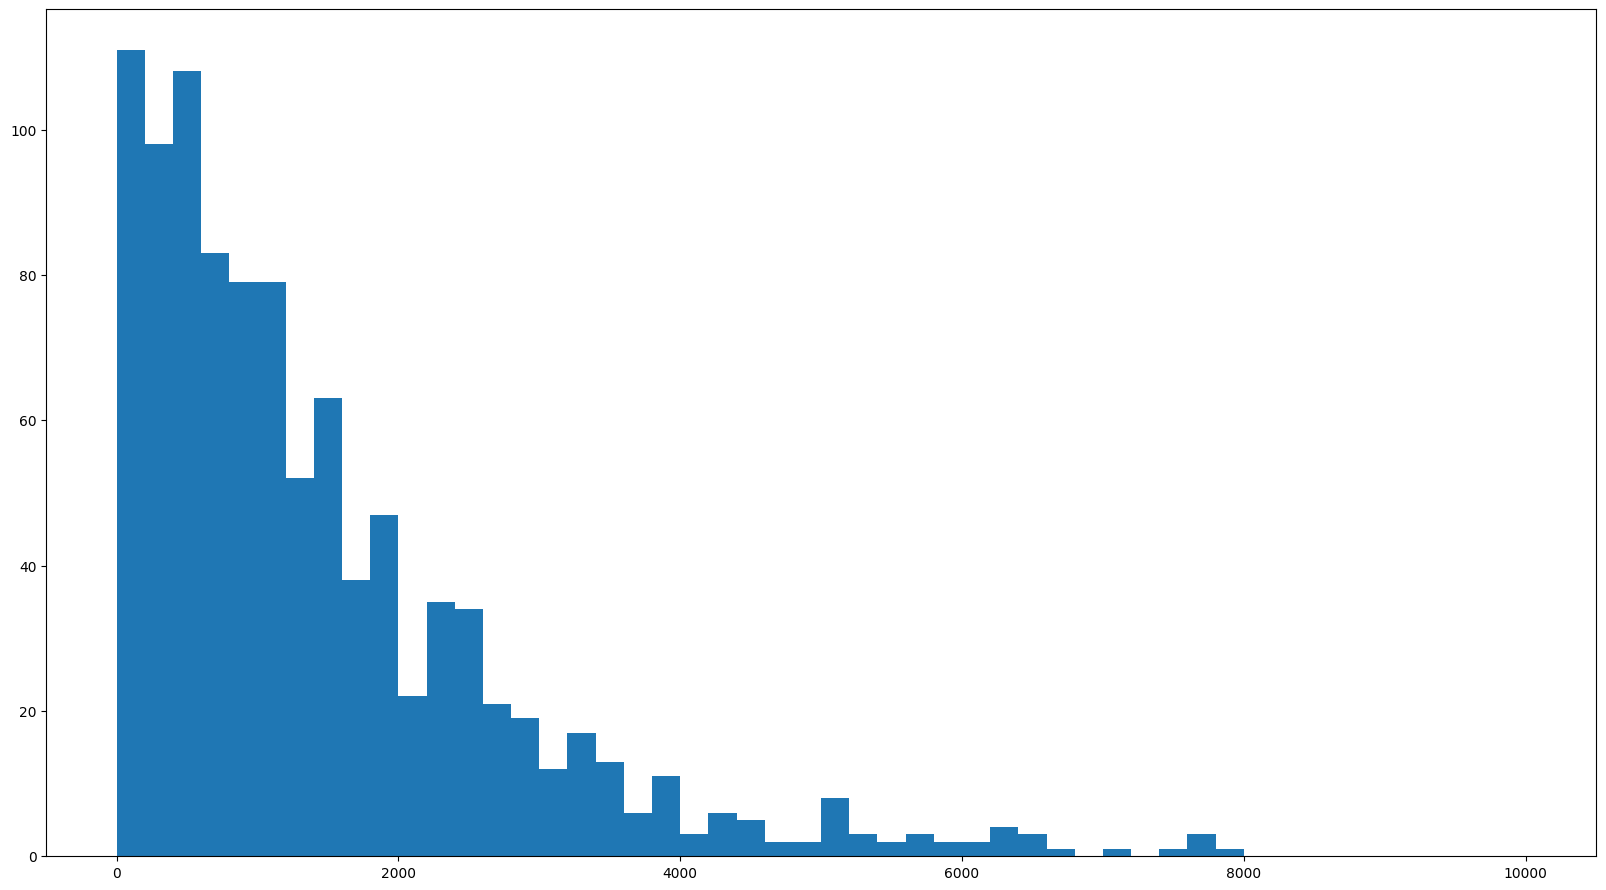

In [44]:
bins=50
plt.hist(T, bins,range=(0,maxT))
print('mean search time:',np.stack(T).mean())
print('median:',median(np.stack(T_success)))
print('std deviation:',np.stack(T).std())

mean search time: 1440.438
std deviation: 1344.0030900842453
median: 1049.0


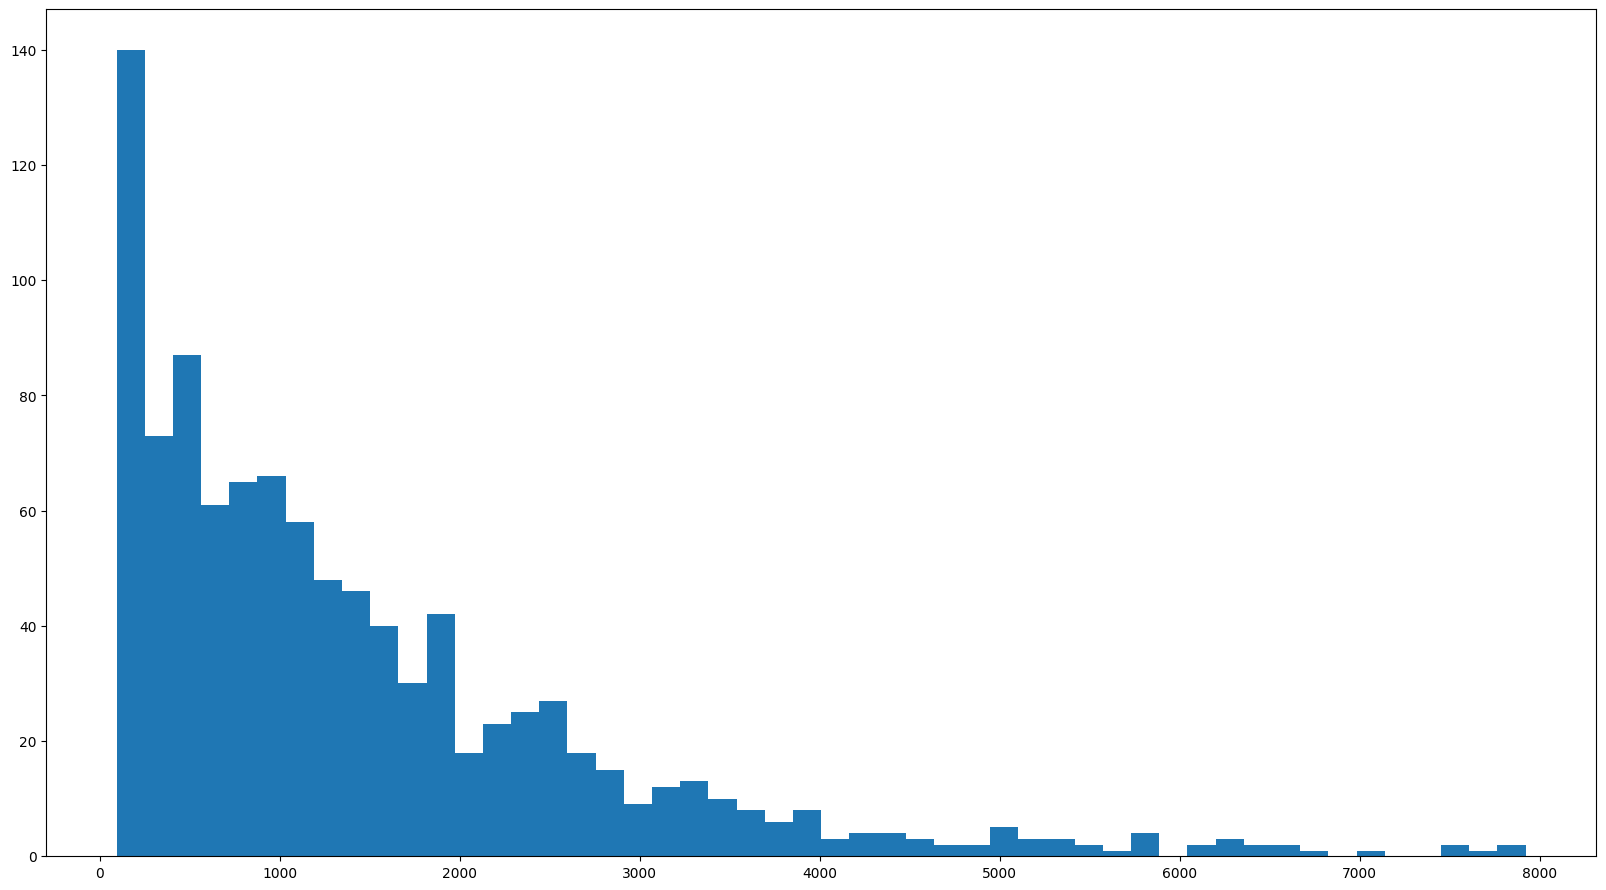

In [43]:
T=np.array(T)
T_success=T[T<maxT]
plt.hist(T_success, bins)
print('mean search time:',np.stack(T_success).mean())
print('median:',median(np.stack(T_success)))
print('std deviation:',np.stack(T_success).std())

<AxesSubplot: ylabel='Density'>

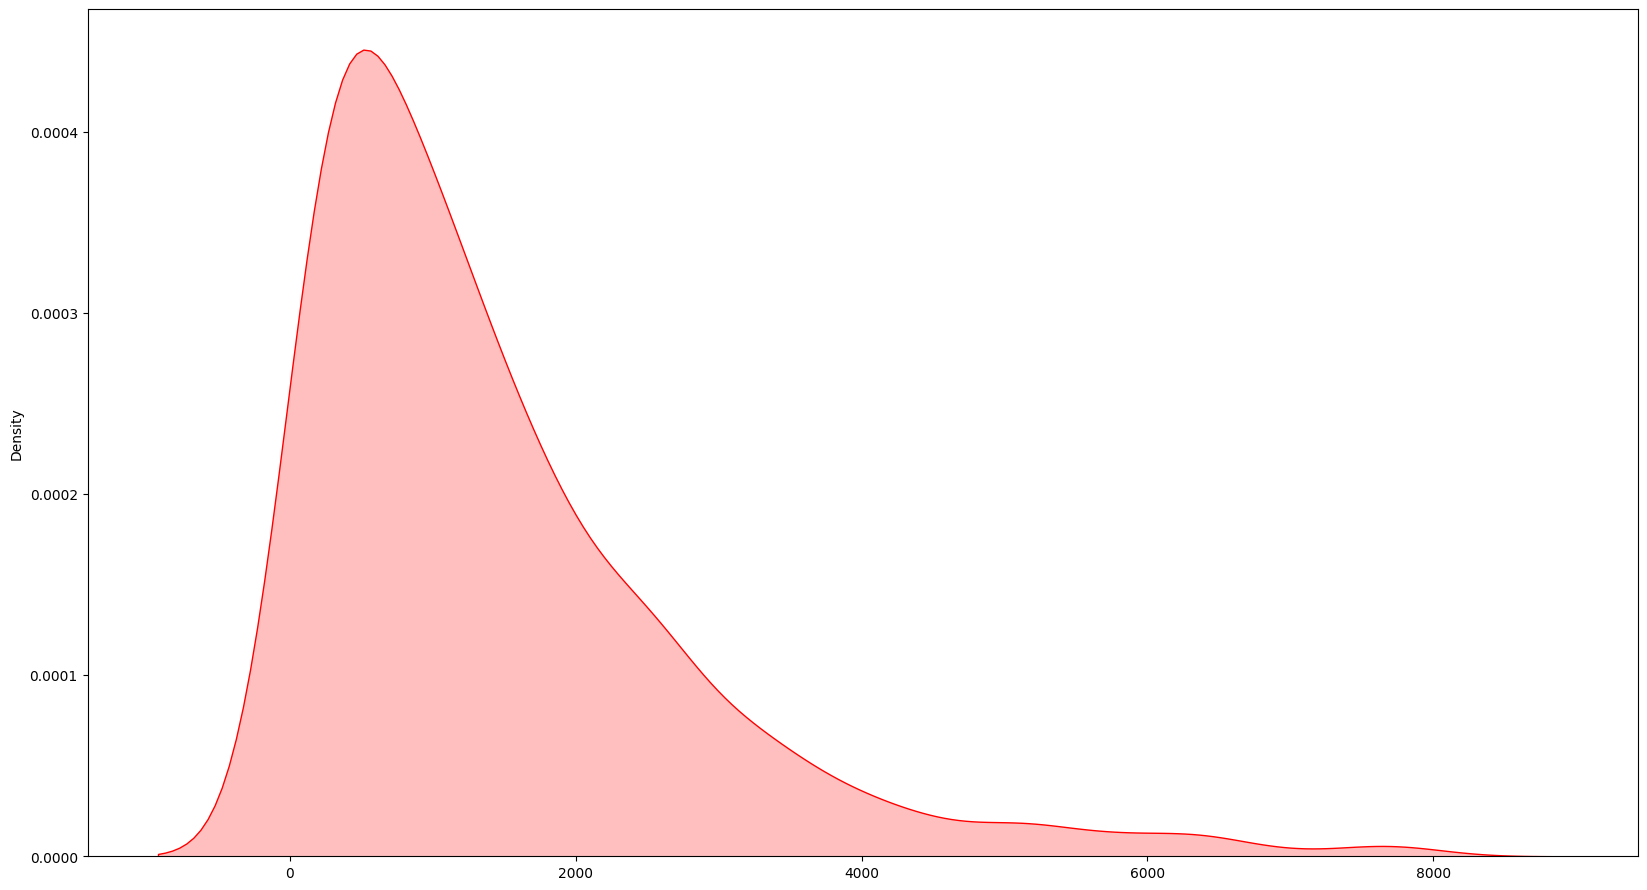

In [41]:
import seaborn as sns
sns.kdeplot(T_success,fill=True,color="red")